In [1]:
import json
import os
import sys
import torch
import numpy as np

# Import our custom modules
sys.path.append("/Users/kkumbier/github/matryoshka-saes/")
from data_generator import HierarchicalDataGenerator

# Define the tree parameter directory
tree_params_dir = "/Users/kkumbier/github/matryoshka-saes/tree_params"

# Load the two configurations we want to analyze
configs = {}

# Load exclusive groups configuration (full parameters)
with open(os.path.join(tree_params_dir, "exclusive_params.json"), 'r') as f:
    configs['exclusive_groups'] = json.load(f)

# Load simple hierarchy configuration (full parameters)  
with open(os.path.join(tree_params_dir, "simple_params.json"), 'r') as f:
    configs['simple_hierarchy'] = json.load(f)


print("Loaded configurations:")
print(json.dumps(configs, indent=2))

Loaded configurations:
{
  "exclusive_groups": {
    "tree_config": {
      "active_prob": 1.0,
      "is_read_out": false,
      "children": [
        {
          "active_prob": 0.3,
          "is_read_out": true,
          "mutually_exclusive_children": true,
          "children": [
            {
              "active_prob": 0.4,
              "is_read_out": true
            },
            {
              "active_prob": 0.6,
              "is_read_out": true
            }
          ]
        }
      ]
    },
    "d_model": 128,
    "feature_correlation": 0.1,
    "orthogonal_features": true,
    "feature_scale_variation": 0.1,
    "random_seed": 123
  },
  "simple_hierarchy": {
    "tree_config": {
      "active_prob": 1.0,
      "is_read_out": false,
      "children": [
        {
          "active_prob": 0.2,
          "is_read_out": true,
          "children": [
            {
              "active_prob": 0.8,
              "is_read_out": true
            },
            {
          

In [2]:
np.random.seed(47)
torch.manual_seed(47)
generator = HierarchicalDataGenerator(**configs["exclusive_groups"])

dataset = generator.create_dataset(
    batch_size=16, num_batches=1, device="cpu"
)

x, activations = dataset.__getitem__(0)
print(x.shape)

Initializing HierarchicalDataGenerator
torch.Size([16, 128])


(1024, 4)


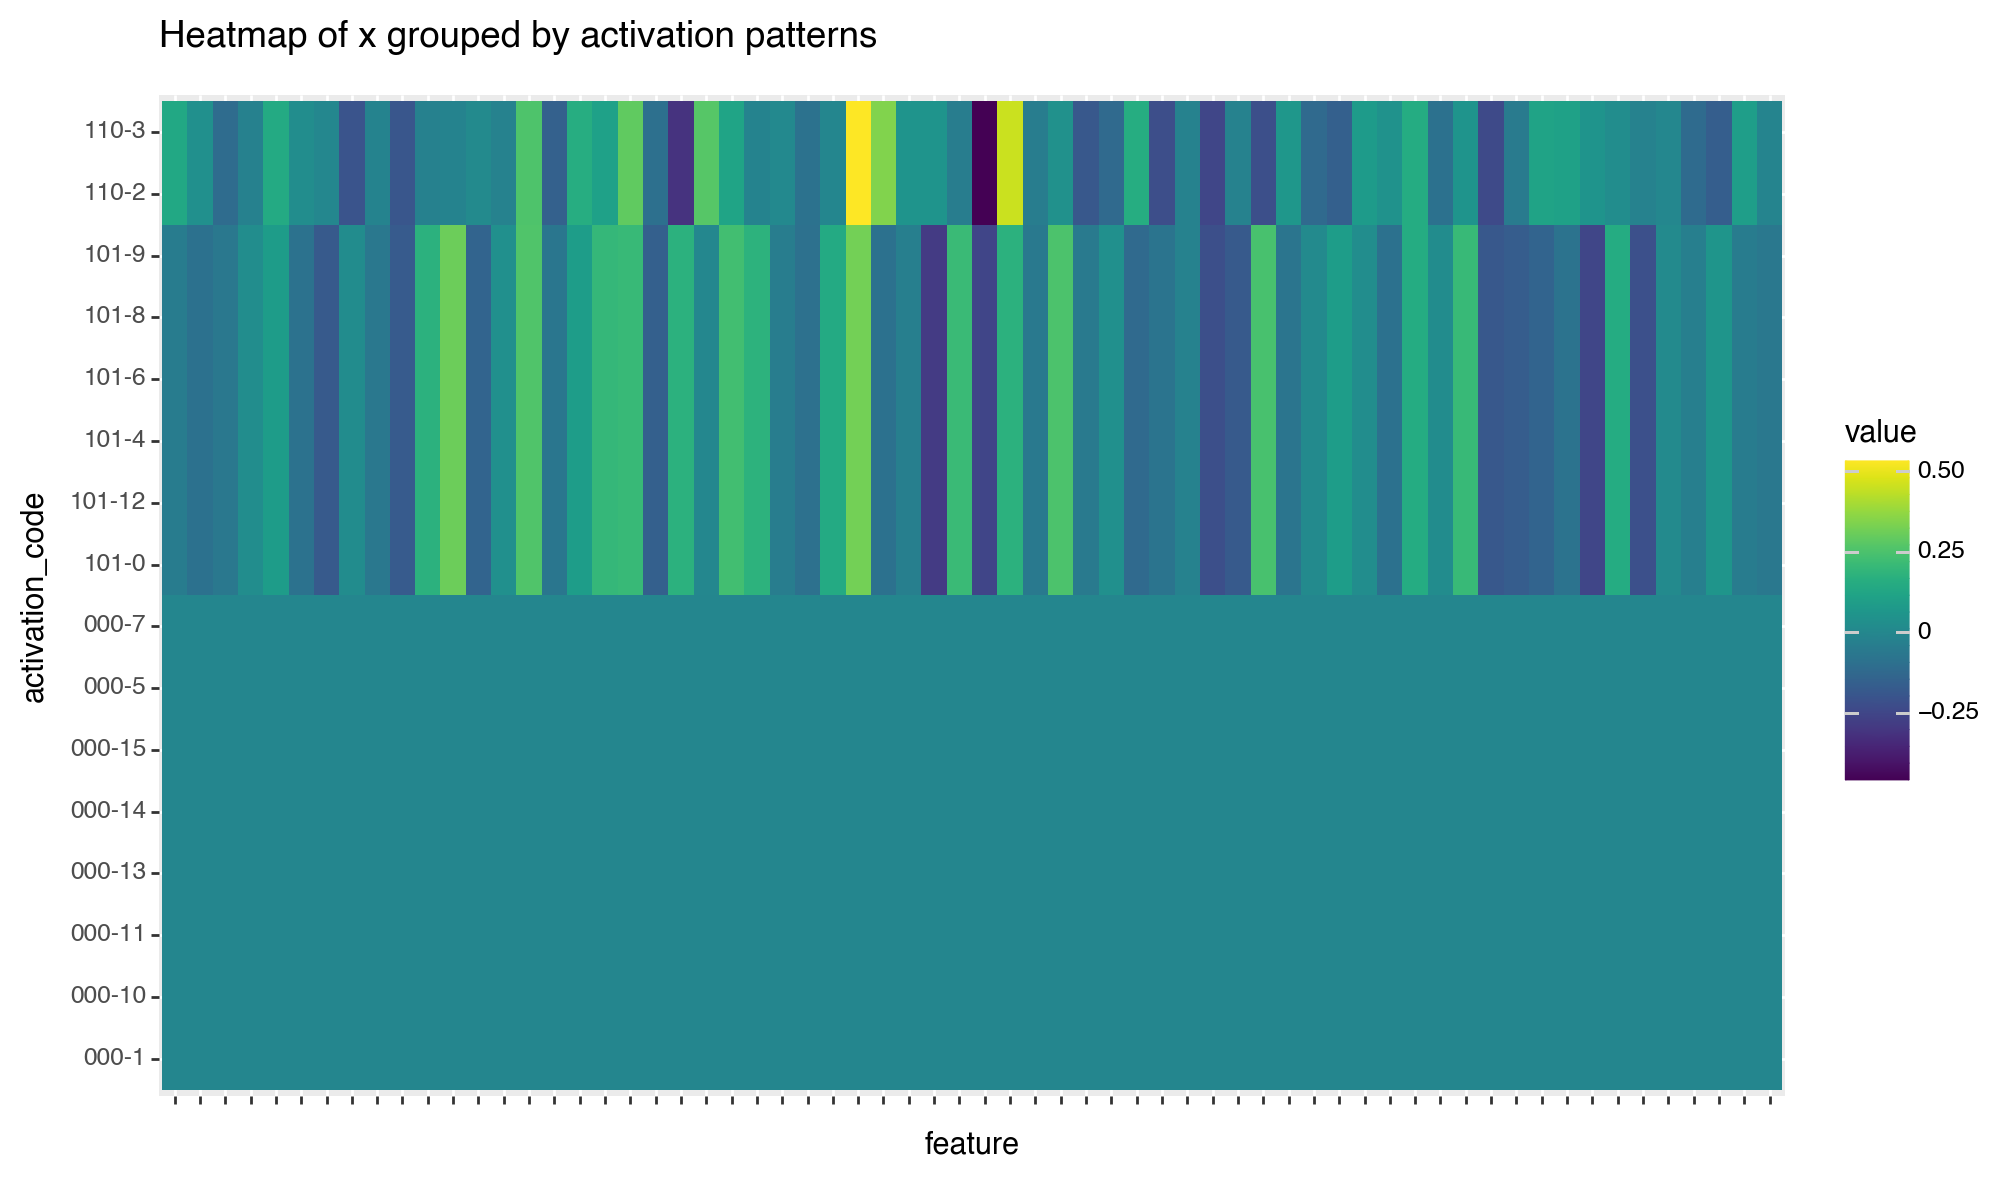

<Figure Size: (1000 x 600)>

In [8]:
import pandas as pd
from plotnine import ggplot, aes, geom_tile, theme, labs, element_blank

# Convert x and activations to numpy
x_np = x[:,:64].numpy()
activations_np = activations.numpy()

# Create a unique code for each activation pattern
activation_codes = [''.join(map(str, map(int, row))) for row in activations_np]

# Build a DataFrame for plotting
df = pd.DataFrame(x_np)
df['row'] = df.index
df['activation_code'] = activation_codes
df['activation_code'] = df.apply(
    lambda row: f"{row['activation_code']}-{row['row']}", axis=1
)

## Melt for heatmap
df_melt = df.melt(
    id_vars=['row', 'activation_code'], var_name='feature', value_name='value'
)
print(df_melt.shape)
# Plot heatmap, grouping by activation_code
(
    ggplot(df_melt, aes('feature', 'activation_code', fill='value')) +
    geom_tile() +
    theme(figure_size=(10, 6)) +
    theme(axis_text_x=element_blank()) +
    labs(title='Heatmap of x grouped by activation patterns')
)